<a href="https://colab.research.google.com/github/emmetorior/CN7030-/blob/main/THURS_Multistock_Classifier%20and%20Cluster_WIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [238]:
!pip install pyspark pandas numpy

In [239]:
#spark.catalog.clearCache()

from pyspark.sql import SparkSession
# Importing package
from pyspark.sql.functions import (
    expr, col, lag, lead, window, stddev, mean, first, last, concat, lit,
    when, abs, isnan, count, dayofmonth, month, year, to_date, udf, abs as spark_abs
)


from pyspark.ml.linalg import Vectors
from pyspark.sql.window import Window
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import StructType, StructField, DoubleType, StringType
from pyspark.sql.functions import udf
import pyspark.sql.functions as F
import pandas as pd
import numpy as np


In [240]:

####
def load_stock_data(data_dir, pd, stock_lookup ):

    df_list = []
    for symbol, name in stock_lookup.items():
      file_path = f"{data_dir}/{symbol}.csv"
      try:
          df = pd.read_csv(file_path)
          print(f"Loading: {symbol}")
          # new column at index 0 (the first col)
          df.insert(0, "symbol", symbol)
          df_list.append(df)
          combined_df = pd.concat(df_list, ignore_index=True)
          df.reset_index()
      except FileNotFoundError:
            print(f"Oops: {symbol} not found...")

    return combined_df

#
stock_lookup = {
        "AAPL": "Apple Inc.",
        "NVDA": "NVIDIA Corp",
        "MSFT": "Microsoft",
        "AMZN": "Amazon",
        "QQQ" : "Invesco QQQ Trust",
        "AVGO": "Broadcom Inc.",
        "TSLA": "Tesla Inc.",
        "COST": "Costco Wholesale Corp",
        "NFLX": "Netflix Inc.",
        "GOOGL": "Alphabet Inc."
    }

data_dir = "/content/drive/MyDrive/stockarchive/full_history"
df = load_stock_data(data_dir, pd, stock_lookup )
df.head(34000)


Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
33995,TSLA,2014-10-13,11268700,238.570007,238.960007,221.000000,224.589996,224.589996
33996,TSLA,2014-10-10,12888300,244.639999,245.889999,235.199997,236.910004,236.910004
33997,TSLA,2014-10-09,7361300,262.250000,265.540009,254.399994,257.010010,257.010010
33998,TSLA,2014-10-08,5055100,260.100006,262.880005,252.639999,259.279999,259.279999


Clean the Data

In [241]:

####
def clean_data(df, pd):

    # fix from source how-to-remove-multiple-headers-row-in-a-pandas-data-frame StackOverflow Quang Hoang
    # Is this a problem? Maybe not.
   # df = df[df.ne(df.columns).any(1)]

    ## more pre cleaning later...
    df['date'] = pd.to_datetime(df['date'])
    #df.set_index('date', inplace=True)
    #df.index
    return df
clean_data(df, pd)


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005
...,...,...,...,...,...,...,...,...
52176,GOOGL,2004-08-25,9188600,52.532532,54.054054,51.991993,53.053055,53.053055
52177,GOOGL,2004-08-24,15247300,55.675674,55.855854,51.836838,52.487488,52.487488
52178,GOOGL,2004-08-23,18256100,55.430431,56.796795,54.579578,54.754753,54.754753
52179,GOOGL,2004-08-20,22834300,50.555557,54.594593,50.300301,54.209209,54.209209


In [242]:
df_qqq = df.loc[ (df['symbol'] == 'QQQ') ]

df_qqq.head()

,symbol,date,volume,open,high,low,close,adjclose
24444,QQQ,2020-07-02,31898400,253.020004,254.270004,251.710007,252.190002,252.190002
24445,QQQ,2020-07-01,34689200,247.639999,251.520004,247.080002,250.490005,250.490005
24446,QQQ,2020-06-30,38909200,242.770004,248.160004,242.580002,247.600006,247.600006
24447,QQQ,2020-06-29,34377800,239.970001,242.850006,237.350006,242.839996,242.839996
24448,QQQ,2020-06-26,52824600,245.779999,245.960007,239.679993,240.220001,240.220001


Set up Spark, and the Spark dataframe is created from the pandas one.
Then we add some additional column data such as the 9 Day moving average, the trading range, and the percentage that the stock has changed since the previous day.

In [243]:
# Create Spark Session
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Classifier").getOrCreate()

df_qqq = spark.createDataFrame(df_qqq)

In [244]:
# 2. Trading Range - daily price range for the stock
df_qqq = df_qqq.withColumn("Trading_Range", col("high") - col("low"))

In [245]:
# 3. Prev Close
df_qqq = df_qqq.withColumn("prev_close", lag("close").over(Window.orderBy("date")))

# 5. price_change_percentage
df_qqq = df_qqq.withColumn("price_change_percentage",
    (col("close") - col("prev_close")) / col("prev_close") * 100
)

In [246]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
df_qqq = df_qqq.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
df_qqq = df_qqq.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
df_qqq = df_qqq.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
df_qqq = df_qqq.filter(F.col("row_id") >= 100).drop("row_id")

# Show the result
#df_qqq_filtered.select("symbol", "date", "close", "9_Day_MA", "100_Day_MA").show(500)
#df_qqq = df_qqq[200:]

Clean up any null values and skip the first few days, since we are using moving averages.


In [247]:
# drop nulls
df_qqq = df_qqq.na.drop()

df_qqq.show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.59375|  56.59375|   -0.27609055770292656| 57.11805555555556|54.419921875|
|   QQQ|1999-08-03 00:00:00|13005000|57.2109375|  57.21875|     55.25|56.0703125| 48.88999

Populate the label column with values as follows:
Either Neutral, or Upward / Downward direction with a small, medium or large move, giving us NEUTRAL, DOWN_SMALL, DOWN_MEDIUM, DOWN_LARGE,  UP_SMALL, UP_MEDIUM, UP_LARGE

UP: +      DOWN: -
NEUTRAL: +- 0.3%
SMALL > 0.3% < 0.6
MEDIUM > 0.6% < 0.9%
LARGE > 0.9%

In [248]:
# Create label column derived from price change percentage and populate it
df_qqq = df_qqq.withColumn(
    "price_change_label", when(abs(col("price_change_percentage")) <= 0.3, "NEUTRAL")\
    .when((abs(col("price_change_percentage")) > 0.3) & (abs(col("price_change_percentage")) <= 0.6), "SMALL")\
    .when((abs(col("price_change_percentage")) > 0.6) & (abs(col("price_change_percentage")) <= 0.9), "MEDIUM")\
    .when(abs(col("price_change_percentage")) > 0.9, "LARGE")\
    .otherwise("NEUTRAL")  # Handle unexpected values
)

# Add "UP" or "DOWN" prefix based on the sign of price_change_percentage
df_qqq = df_qqq.withColumn(
    "price_change_label",
    when(col("price_change_percentage") > 0, concat(lit("UP-"), col("price_change_label")))
    .otherwise(concat(lit("DOWN-"), col("price_change_label")))
)

In [249]:

# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

In [250]:


# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel'
)

# Check if 'indexlabel' column already exists
if 'indexlabel' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'indexlabel' already exists. Skipping StringIndexer.")


In [251]:
# Split data
(train_data, test_data) = prepared_df.select('features', 'indexlabel').randomSplit([0.7, 0.3], seed=42)

# Train the Logistic Regression with max 10 iterations
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='indexlabel',  # Make sure labelCol matches the outputCol of StringIndexer
    featuresCol='features'
)
model = lr.fit(train_data)

In [252]:
# Evaluate the model
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Logistic Regression: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

Logistic Regression: Model Accuracy: 0.35003295978905735 
35%


In [253]:

# Prepare features again
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','100_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
#We need to redefine the df again
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
# Convert label column to numerical indexes (remains the same)
label_indexer2 = StringIndexer(
    inputCol='price_change_label',
    outputCol='indexlabel2'
)

# Check if 'indexlabel2' column already exists (remains the same)
if 'indexlabel2' not in prepared_df.columns:
    prepared_df = label_indexer2.fit(prepared_df).transform(prepared_df)
else:
    print("already exists. Skipping.")

# Split data (remains the same)
(train_data, test_data) = prepared_df.select('features', 'indexlabel2').randomSplit([0.7, 0.3], seed=42)

# Train the Decision Tree Classifier
dt = DecisionTreeClassifier(
      #7 zones - auto detected I think in this version. numClasses=7
    maxDepth=5,  # Hyperparameter - fix this
    impurity="gini",  # Impurity
    seed=42,  #
    labelCol='indexlabel2', # Changed to use 'indexlabel2' as the label column
    featuresCol='features'
)
model = dt.fit(train_data)

# Evaluate the model (remains the same)
predictions = model.transform(test_data)
evaluator = MulticlassClassificationEvaluator(
    labelCol='indexlabel2',
    predictionCol='prediction',
    metricName='accuracy'
)
accuracy = evaluator.evaluate(predictions)
print(f"Decision Tree: Model Accuracy: {accuracy} ")
print(f"{int(np.round(accuracy * 100))}%")

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

EVALUATE THE LABELS

In [254]:
#Prepare Features again #3
# Prepare features
#feature_columns = ['open', 'close', 'high', 'low', 'volume']
feature_columns = ['open', 'close', 'high', 'low', 'volume','9_Day_MA','Trading_Range','price_change_percentage']

assembler = VectorAssembler(
    inputCols=feature_columns,
    outputCol='features'
)
prepared_df = assembler.transform(df_qqq)
prepared_df.show()
#-
# Convert label column to numerical indexes
label_indexer = StringIndexer(
    inputCol='price_change_label',
    outputCol='label'
)

# Check if 'indexlabel3' column already exists
if 'label' not in prepared_df.columns:
    prepared_df = label_indexer.fit(prepared_df).transform(prepared_df)
else:
    print("Column 'label' already exists. Skipping StringIndexer.")
#-
# Split data
(train_data, test_data) = prepared_df.select('features', 'label').randomSplit([0.7, 0.3], seed=42)

#---------------------------------------------
# replace original columns here - like in the previous one. I just wrote this app with reduced features to make it easier to create.
prepared_df = prepared_df.withColumn('open', col('open')) \
    .withColumn('close', col('close')) \
    .withColumn('price_change_percentage', col('price_change_percentage'))
    #.withColumn('price_change_label', col('price_change_label'))

# Split into training and test sets
(train_data, test_data) = prepared_df.randomSplit([0.7, 0.3], seed=42)

# Training the log reg
lr = LogisticRegression(
    maxIter=10,
    regParam=0.3,
    elasticNetParam=0.8,
    labelCol='label',
    featuresCol='features'
)
model = lr.fit(train_data)

# predict
predictions = model.transform(test_data)
predictions.select('prediction').show()

+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|symbol|               date|  volume|      open|      high|       low|     close|          adjclose|Trading_Range|prev_close|price_change_percentage|          9_Day_MA|  100_Day_MA|price_change_label|            features|
+------+-------------------+--------+----------+----------+----------+----------+------------------+-------------+----------+-----------------------+------------------+------------+------------------+--------------------+
|   QQQ|1999-07-30 00:00:00|10947400|    57.125|     57.75|56.5078125|  56.59375| 49.34638595581055|    1.2421875|    56.875|   -0.49450549450549447| 57.33680555555556|54.366171875|        DOWN-SMALL|[57.125,56.59375,...|
|   QQQ|1999-08-02 00:00:00| 9642400|   56.6875|   57.8125|  56.21875|   56.4375| 49.21015167236328|      1.5937

In [255]:
# Define the mapping function
def map_prediction_to_label(prediction):
    temp = prediction
    pred = np.double(prediction)
    if (temp  < 0.3 ) and( temp >- 0.3):
      temp = "NEUTRAL"
    elif (temp>0.3):
      temp = "UP-"
    elif (temp<-0.3):
      temp = "DOWN-"

    tmpPred = np.abs(pred)

    if tmpPred < 0.3:
        tmpPredDesc = ''
    elif tmpPred < 0.6:
        tmpPredDesc = 'SMALL'
    elif tmpPred < 0.9:
        tmpPredDesc = 'MEDIUM'
    else:
        tmpPredDesc = 'LARGE'

    return temp + tmpPredDesc

# Register the function as a UDF
map_prediction_udf = udf(map_prediction_to_label, StringType())

# Use the UDF in the DataFrame
results_df = predictions.select(
    'open',
    'close',
    'price_change_percentage',
    'price_change_label',
    'prediction',
    map_prediction_udf(col('prediction')).alias('predicted_label')
)

# Display results
results_df.show()

+----------+----------+-----------------------+------------------+----------+---------------+
|      open|     close|price_change_percentage|price_change_label|prediction|predicted_label|
+----------+----------+-----------------------+------------------+----------+---------------+
|57.2109375|56.0703125|     -0.650609080841639|       DOWN-MEDIUM|       0.0|        NEUTRAL|
|  55.53125|54.6171875|    -1.2849477548715051|        DOWN-LARGE|       1.0|       UP-LARGE|
|  55.09375|  55.90625|     3.2909930715935336|          UP-LARGE|       0.0|        NEUTRAL|
|    56.125|     55.25|    -1.1738401341531581|        DOWN-LARGE|       1.0|       UP-LARGE|
|    58.125|     57.75|    -1.1235955056179776|        DOWN-LARGE|       1.0|       UP-LARGE|
|  57.21875|   57.0625|    -1.1904761904761905|        DOWN-LARGE|       1.0|       UP-LARGE|
|    57.125|  57.96875|     1.5881708652792992|          UP-LARGE|       0.0|        NEUTRAL|
|      61.5|60.4765625|    -1.6641260162601625|        DOWN-

In [256]:
# Basic preprocessing

#Adjust cleaning threshold: If a significant number of closing prices are missing but some data remains valuable, you could adjust the dropna function. For example, instead of dropping all rows with missing values, you could specify a threshold (e.g., dropna(thresh=0.8)) to keep rows with at least 80% of the data points.
#stock_data.dropna(inplace=True)
#print(f"Stock data shape after cleaning: {stock_data.shape}")
# check if this dataframe is empty
#if not stock_data.empty:  # Check if DataFrame is not empty
  # Existing feature calculation code (e.g., Daily_Percent_Change)


#import pandas as pd
# data = yf.download(tickers='AAPL', period='5d', interval='5m')
# pd.set_option('display.max_rows', None)
# df = pd.DataFrame(data)

# Calculate features
#stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()
#stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
#Impute missing values: Consider filling missing values with a specific strategy like the mean, median, or a forward/backward fill approach. Pandas offers functions like fillna for this purpose.

# Skip the first 200 rows to avoid NaN values due to moving averages
#stock_data = stock_data.iloc[200:]

CLUSTERING

**Clustering workflow  (citation: workflow steps taken from google machine learning )
*   Prepare data.
*   Create Similarity Metric.
*   Run clustering algorithm.
*   Interpret results and adjust your clustering.
*   Run clustering algorithm.

Prepare data
As with any ML problem, you must normalize, scale, and transform feature data before training or fine-tuning a model on that data. In addition, before clustering, check that the prepared data lets you accurately calculate similarity between examples.

Review: For a review of data transformation, see Working with numerical data from Machine Learning Crash Course.
Create similarity metric
Before a clustering algorithm can group data, it needs to know how similar pairs of examples are. You can quantify the similarity between examples by creating a similarity metric, which requires a careful understanding of your data.

Run clustering algorithm
A clustering algorithm uses the similarity metric to cluster data. This course uses k-means.

Interpret results and adjust
Because clustering doesn't produce or include a ground "truth" against which you can verify the output, it's important to check the result against your expectations at both the cluster level and the example level. If the result looks odd or low-quality, experiment with the previous three steps. Continue iterating until the quality of the output meets your needs.

In [257]:
stock_lookup = {
        "AAPL": "Apple Inc.",
        "NVDA": "NVIDIA Corp",
        "MSFT": "Microsoft",
        "AMZN": "Amazon",
        "QQQ" : "Invesco QQQ Trust",
        "AVGO": "Broadcom Inc.",
        "TSLA": "Tesla Inc.",
        "COST": "Costco Wholesale Corp",
        "NFLX": "Netflix Inc.",
        "GOOGL": "Alphabet Inc.",
        "GM"  :"General Motors Inc",
        "WMT":"Walmart",
        "RYAAY":"Ryanair",
        "MTSI" : "Macom Technologies"
    }



In [258]:

from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set()  # for plot styling

import pickle


In [259]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Load
data_dir = "/content/drive/MyDrive/stockarchive/full_history"
stock_df = load_stock_data(data_dir, pd, stock_lookup)

stock_df.head() #pandas df
# Ensure correct data types and inspect data
#stock_df.info()

Loading: AAPL
Loading: NVDA
Loading: MSFT
Loading: AMZN
Loading: QQQ
Loading: AVGO
Loading: TSLA
Loading: COST
Loading: NFLX
Loading: GOOGL
Loading: GM
Loading: WMT
Loading: RYAAY
Loading: MTSI


,symbol,date,volume,open,high,low,close,adjclose
0,AAPL,2020-07-02,28484300,367.850006,370.470001,363.640015,364.109985,364.109985
1,AAPL,2020-07-01,27684300,365.119995,367.359985,363.910004,364.109985,364.109985
2,AAPL,2020-06-30,35055800,360.079987,365.980011,360.000000,364.799988,364.799988
3,AAPL,2020-06-29,32661500,353.250000,362.170013,351.279999,361.779999,361.779999
4,AAPL,2020-06-26,51314200,364.410004,365.320007,353.019989,353.630005,353.630005


In [260]:
stock_df = stock_df.dropna(how='all', axis=1)  # Changed the order of arguments

#stock_df = stock_df.withColumn('date', to_date(stock_df['date']))


In [261]:
# Calculate 'price_change_percentage' before using it for clustering
# Assuming 'close' is the closing price column
stock_df['price_change_percentage'] = stock_df['close'].pct_change() * 100



In [262]:
spark.catalog.clearCache()

# Create Spark Session
spark = SparkSession.builder.appName("CN7030 Assn 1 - Stock Price Clustering").getOrCreate()

stock_df = spark.createDataFrame(stock_df)

In [263]:
# 2. Trading Range - daily price range for the stock
stock_df = stock_df.withColumn("Trading_Range", col("high") - col("low"))


In [288]:

# 3. Prev Close
stock_df = stock_df.withColumn("prev_close", lag("close").over(Window.orderBy("date")))

# 5. price_change_percentage
stock_df = stock_df.withColumn("price_change_percentage",
    (col("close") - col("prev_close")) / col("prev_close") * 100
)

In [300]:
# Create a Window specification partitioned by symbol and ordered by date

#windowSpec30Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-30, -1)

# Calculate moving averages
#stock_df = stock_df.withColumn("30_Day_Return", (F.col("close") - F.col(lag("close", 30))).over(windowSpec30Day))
# 3. Prev Close
#

#w = Window.partitionBy('symbol', 'language').orderBy('month')
w = Window.partitionBy("symbol").orderBy("date").rowsBetween(-1, -1)
stock_df = stock_df.withColumn("Monthly_Return", (col("close") - lag("close", 1).over(w)) / lag("close", 1).over(w) * 100 )
# Filter out rows with null Monthly_Return
stock_df = stock_df.filter(col("Monthly_Return").isNotNull())
stock_df.show(500)

+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+-------------------+------------+--------------------+
|symbol|      date|  volume|              open|              high|               low|             close|          adjclose|price_change_percentage|       Trading_Range|  prev_close|      30_Day_Return| prev_close2|      Monthly_Return|
+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+-------------------+------------+--------------------+
|  AAPL|1980-12-15|43971200|0.4888392984867096|0.4888392984867096|0.4866071343421936|0.4866071343421936|0.3845173120498657|     143.06619783727135|0.002232164144515991|0.2001953125|                0.0|0.2001953125|  -5.217394534942054|
|  AAPL|1980-12-16|26432000|          0.453125|         

In [266]:
stock_df = stock_df.withColumn("30_Day_Return", (col("prev_close") - lag("prev_close", 30).over(Window.orderBy("date"))))
stock_df.show()

+------+----------+-------+--------------+--------------+--------------+--------------+--------------+-----------------------+--------------+--------------+-------------+
|symbol|      date| volume|          open|          high|           low|         close|      adjclose|price_change_percentage| Trading_Range|    prev_close|30_Day_Return|
+------+----------+-------+--------------+--------------+--------------+--------------+--------------+-----------------------+--------------+--------------+-------------+
|   WMT|1972-08-25|2508800|  0.0634765625|0.064697265625|  0.0634765625|   0.064453125|   0.064453125|                   NULL|0.001220703125|          NULL|         NULL|
|   WMT|1972-08-28| 972800|   0.064453125| 0.06494140625|0.064208984375|0.064208984375|0.064208984375|    -0.3787878787878788| 7.32421875E-4|   0.064453125|         NULL|
|   WMT|1972-08-29|1945600| 0.06396484375| 0.06396484375|  0.0634765625|  0.0634765625|  0.0634765625|    -1.1406844106463878|  4.8828125E-4|0.06

In [301]:

windowSpec9Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-8, 0)
windowSpec100Day = Window.partitionBy("symbol").orderBy("date").rowsBetween(-99, 0)

# Calculate moving averages
stock_df = stock_df.withColumn("9_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec9Day))
stock_df = stock_df.withColumn("100_Day_MA", F.avg(F.col("close").cast("float")).over(windowSpec100Day))

# *row skipping solution from stackexchange
stock_df = stock_df.withColumn("row_id", F.row_number().over(Window.partitionBy("symbol").orderBy("date")))
stock_df = stock_df.filter(F.col("row_id") >= 100).drop("row_id")

# Show the result
#stock_df_filtered.select("symbol", "date", "close", "9_Day_MA", "100_Day_MA").show(500)
#stock_df = stock_df[200:]

# drop nulls
stock_df = stock_df.na.drop()

stock_df.show()

+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+-------------+------------+--------------------+------------------+-------------------+
|symbol|      date|  volume|              open|              high|               low|             close|          adjclose|price_change_percentage|       Trading_Range|  prev_close|30_Day_Return| prev_close2|      Monthly_Return|          9_Day_MA|         100_Day_MA|
+------+----------+--------+------------------+------------------+------------------+------------------+------------------+-----------------------+--------------------+------------+-------------+------------+--------------------+------------------+-------------------+
|  AAPL|1981-05-07| 2340800|0.4955357015132904|0.4977678656578064|0.4955357015132904|0.4955357015132904|0.3915725946426391|      63.68663172568044|0.002232164144515991| 0.302734375| 0.024414062

In [302]:

# Drop missing values if any, including those introduced by pct_change
stock_df = stock_df[["close", "volume", "Trading_Range", "9_Day_MA","100_Day_MA","price_change_percentage", "Monthly_Return"]].dropna()

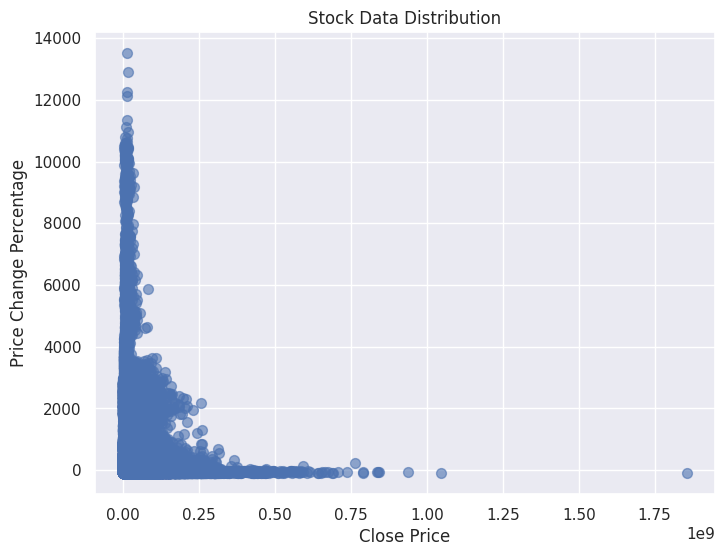

In [215]:
#convert back to pandas for the scatterplot
stock_df_pd = stock_df.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(stock_df_pd["volume"], stock_df_pd["price_change_percentage"], s=50, alpha=0.6)
plt.title("Stock Data Distribution")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()

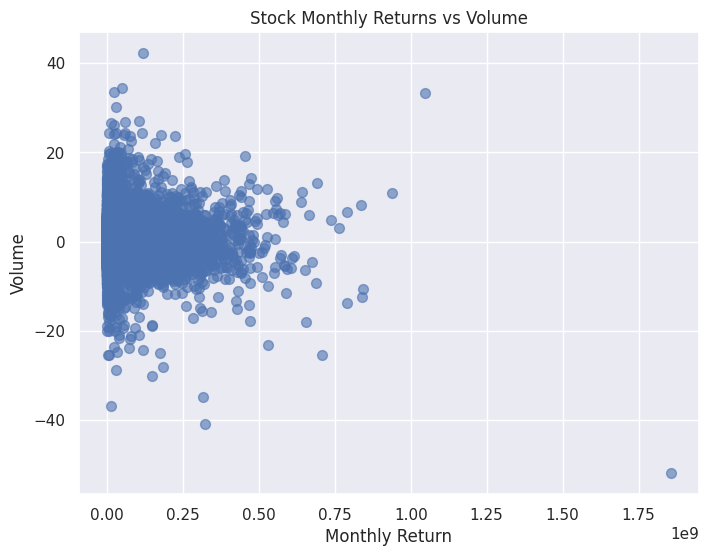

In [306]:
#new copy
stock_df_pd = stock_df.toPandas()

# Visualize initial data distribution
plt.figure(figsize=(8, 6))
#plt.scatter(stock_data["close"], stock_data["price_change_percentage"], s=50, alpha=0.6)
plt.scatter(stock_df_pd["volume"], stock_df_pd["Monthly_Return"], s=50, alpha=0.6)
plt.title("Stock Monthly Returns vs Volume")
plt.xlabel("Monthly Return")
plt.ylabel("Volume")
plt.show()

Cluster Counts: {0: 13874, 1: 557, 2: 3527, 3: 55250}


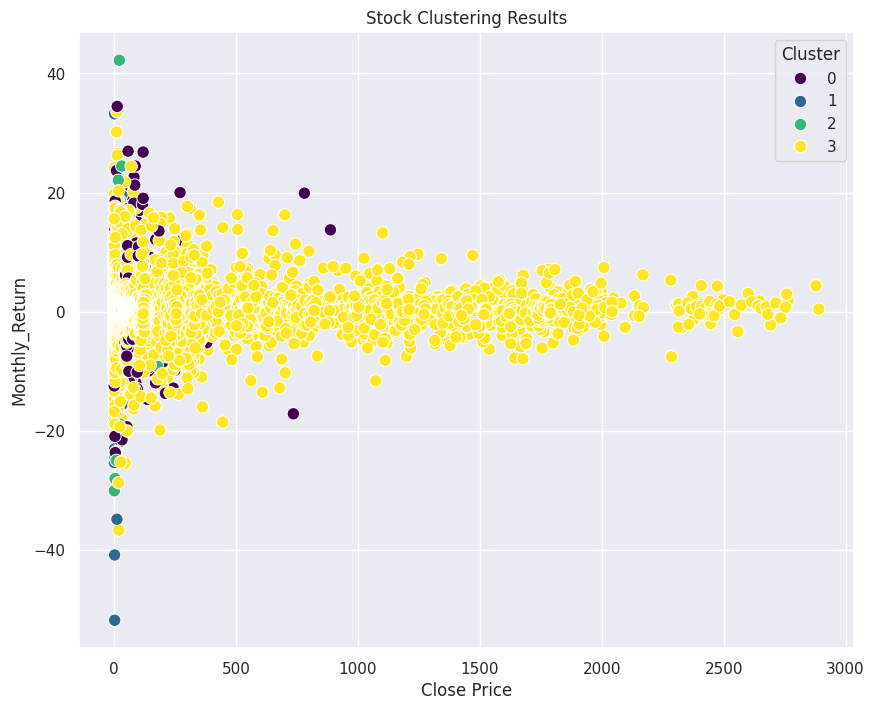

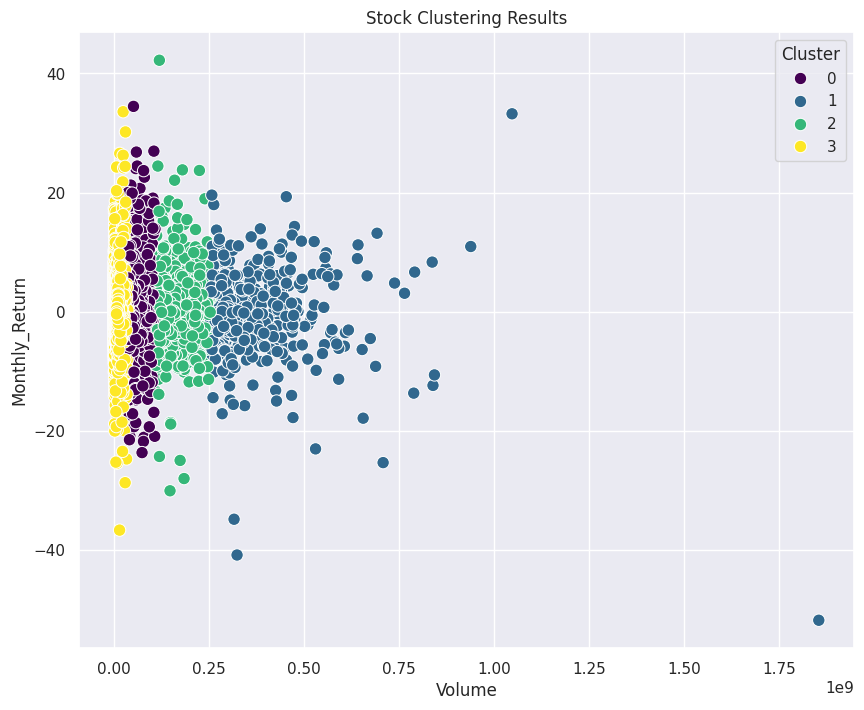

In [318]:
# Train a KMeans model
model = KMeans(n_clusters=4, random_state=42)
model.fit(stock_df_pd)

# Save the model to a pickle file
pickle_filename = "kmeans_stock_model.pickle"
pickle.dump(model, open(pickle_filename, "wb"))

# Load the model from the pickle file
loaded_model = pickle.load(open(pickle_filename, "rb"))

# Get cluster labels
labels = loaded_model.labels_

# Count number of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)
print("Cluster Counts:", dict(zip(unique_labels, label_counts)))

# Add labels to DataFrame
stock_df_pd["Cluster"] = labels

#"volume", "Trading_Range", "9_Day_MA","100_Day_MA","price_change_percentage", "Monthly_Return"
# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["close"],
    y=stock_df_pd["Monthly_Return"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Close Price")
plt.ylabel("Monthly_Return")
plt.show()


# Visualize the clusters
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_df_pd["volume"],
    y=stock_df_pd["Monthly_Return"],
    hue=stock_df_pd["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results")
plt.xlabel("Volume")
plt.ylabel("Monthly_Return")
plt.show()


In [308]:
print(f"Stock data shape : {stock_df_pd.shape}")

Stock data shape after cleaning: (73208, 7)


KeyError: 'Volume'

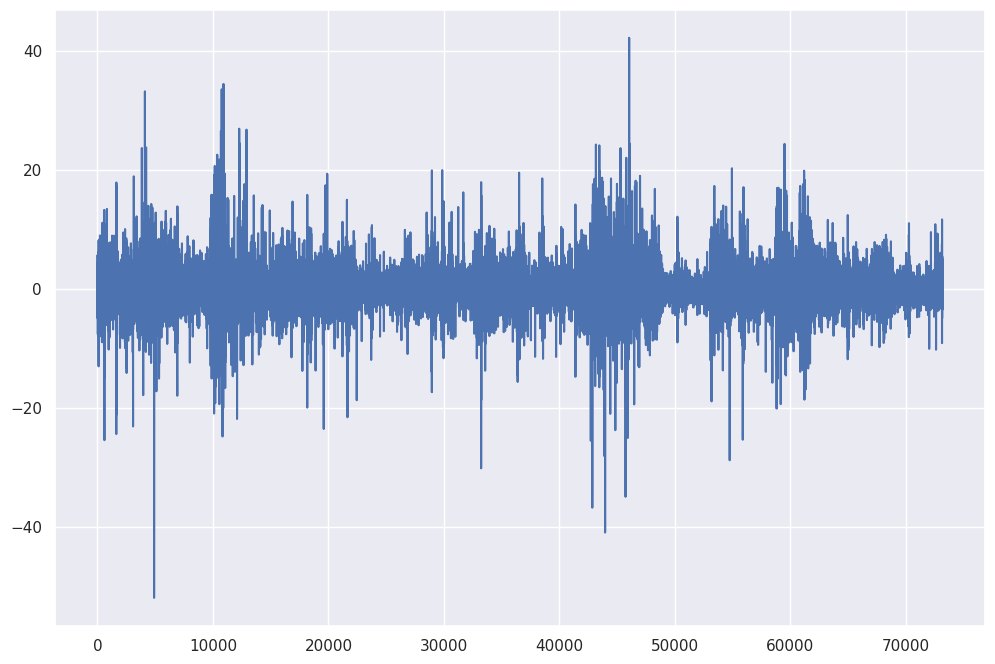

In [316]:
#stock_data.dropna(inplace=True)

#print(f"Stock data shape after cleaning: {stock_data.shape}")
# Visualize the features
plt.figure(figsize=(12, 8))
plt.plot(stock_df_pd.index, stock_df_pd['Monthly_Return'], label='Monthly_Return')
plt.plot(stock_df_pd.index, stock_df_pd['Volume'], label='Volume', alpha=0.5)
plt.plot(stock_df_pd.index, stock_df_pd['100_Day_MA'], label='100_Day_MA', alpha=0.8)
#plt.plot(stock_df_pd.index, stock_df_pd['MA50'], label='MA50', alpha=0.8)
#plt.fill_between(stock_df_pd.index, stock_df_pd['BB_upper'], stock_df_pd['BB_lower'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.title(f"{symbol} Feature Visualization")
plt.show()

[*********************100%***********************]  1 of 1 completed


Stock data shape after cleaning: (501, 6)
Stock data shape after cleaning: (432, 12)


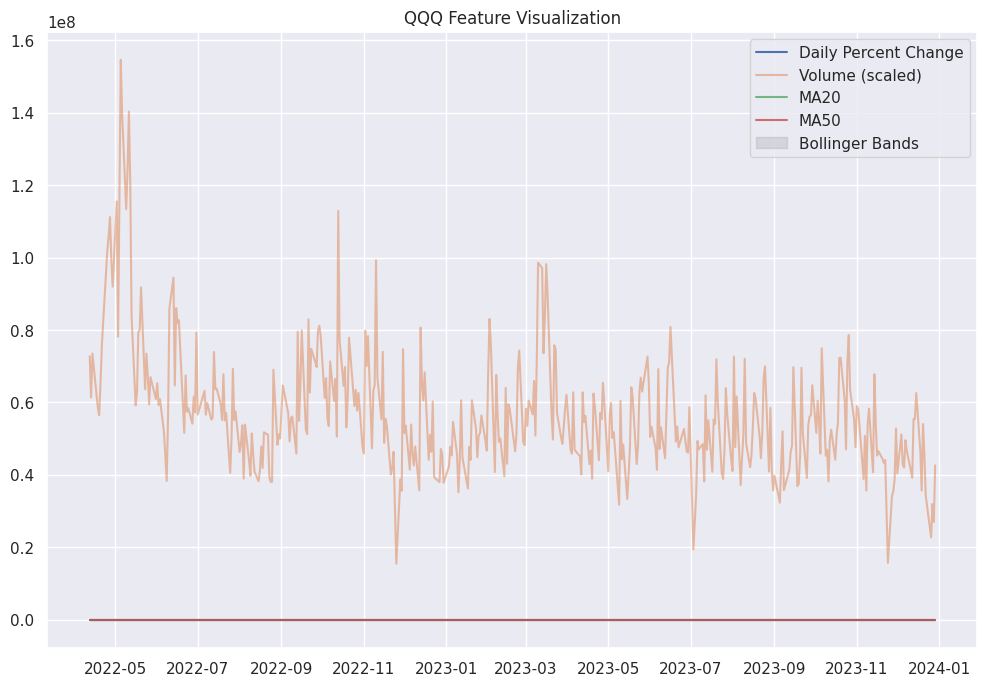

Silhouette Score for K-Means Clustering: 0.36


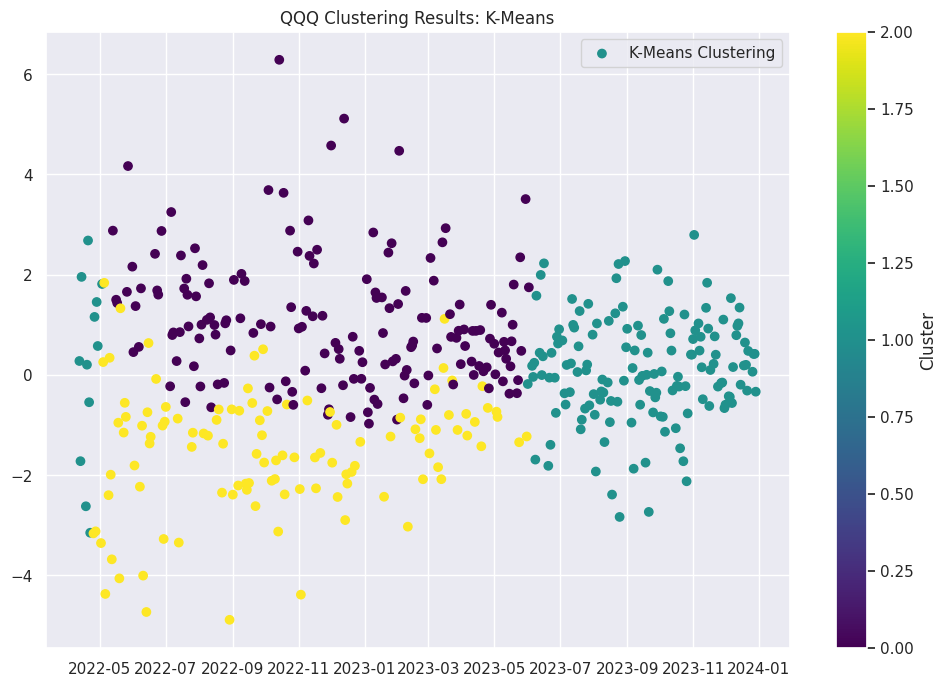

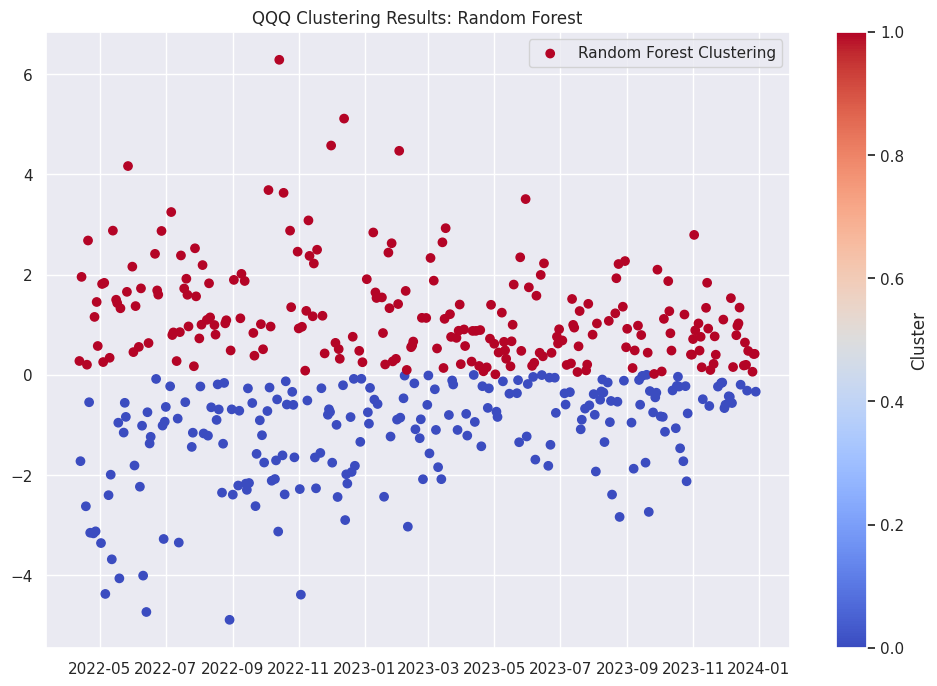

            Daily_Percent_Change  Cluster_KMeans  Cluster_RF
Date                                                        
2022-04-12              0.275518               1           1
2022-04-13             -1.723745               1           0
2022-04-14              1.954095               1           1
2022-04-18             -2.623830               1           0
2022-04-19              0.201569               1           1


In [309]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


#stock_data.dropna(inplace=True)

#print(f"Stock data shape after cleaning: {stock_data.shape}")
# Visualize the features
plt.figure(figsize=(12, 8))
plt.plot(stock_df.index, stock_df['Daily_Percent_Change'], label='Daily Percent Change')
plt.plot(stock_df.index, stock_df['Volume'], label='Volume (scaled)', alpha=0.5)
plt.plot(stock_df.index, stock_df['MA20'], label='MA20', alpha=0.8)
plt.plot(stock_df.index, stock_df['MA50'], label='MA50', alpha=0.8)
plt.fill_between(stock_df.index, stock_df['BB_upper'], stock_df['BB_lower'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} Feature Visualization")
plt.show()

# Prepare data for clustering
features = stock_data[['Daily_Percent_Change', 'Volume', 'MA20', 'MA50', 'BB_upper', 'BB_lower']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stock_data['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

# Random Forest for supervised clustering
# Create a target variable: for simplicity, we classify into up/down based on daily percent change
stock_data['Target'] = np.where(stock_data['Daily_Percent_Change'] > 0, 1, 0)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_features, stock_data['Target'])

# Add Random Forest Predictions
stock_data['Cluster_RF'] = rf.predict(scaled_features)

# Evaluate clustering using silhouette score (for K-Means)
silhouette_avg = silhouette_score(scaled_features, stock_data['Cluster_KMeans'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.2f}")

# Plot the clustering results
plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_KMeans'], cmap='viridis', label='K-Means Clustering')
plt.title(f"{ticker} Clustering Results: K-Means")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_RF'], cmap='coolwarm', label='Random Forest Clustering')
plt.title(f"{ticker} Clustering Results: Random Forest")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Summary and insights
print(stock_data[['Daily_Percent_Change', 'Cluster_KMeans', 'Cluster_RF']].head())
# Visualize the features (adjust plot to include new columns)
# ...





In [305]:
from sklearn.preprocessing import StandardScaler

# Scale features
scaler = StandardScaler()
scaled_data = scaler.fit_transform(stock_data[["close", "volume", "price_change_percentage", "9_Day_MA","100_Day_MA"]])

# Train KMeans model with scaled data
model = KMeans(n_clusters=4, random_state=42)
model.fit(scaled_data)

# Save and reload the model
pickle_filename = "kmeans_stock_model_scaled.pickle"
pickle.dump(model, open(pickle_filename, "wb"))
loaded_model = pickle.load(open(pickle_filename, "rb"))

# Get cluster labels
labels = loaded_model.labels_

# Count labels
unique_labels, label_counts = np.unique(labels, return_counts=True)
print("Cluster Counts:", dict(zip(unique_labels, label_counts)))

# Add labels back to DataFrame
stock_data["Cluster"] = labels

#
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=stock_data["close"],
    y=stock_data["price_change_percentage"],
    hue=stock_data["Cluster"],
    palette="viridis", s=80
)
plt.title("Stock Clustering Results with Scaled Features")
plt.xlabel("Close Price")
plt.ylabel("Price Change Percentage")
plt.show()

KeyError: "None of [Index(['close', 'volume', 'price_change_percentage', '9_Day_MA', '100_Day_MA'], dtype='object')] are in the [columns]"

In [ ]:
# Ensure the result of the rolling calculation is a Series by using .values
stock_data['BB_upper'] = stock_data['MA20'] + (2 * stock_data['Close'].rolling(window=20).std(ddof=0)['Close'])
#stock_data['BB_upper'] = stock_data['MA20'] + (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)
stock_data['BB_lower'] = stock_data['MA20'] - (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)
stock_data['Daily_Percent_Change'] = stock_data['Close'].pct_change() * 100
stock_data['Volume'] = stock_data['Volume']



In [ ]:
stock_data.dropna(inplace=True)

print(f"Stock data shape after cleaning: {stock_data.shape}")
# Visualize the features
plt.figure(figsize=(12, 8))
plt.plot(stock_data.index, stock_data['Daily_Percent_Change'], label='Daily Percent Change')
plt.plot(stock_data.index, stock_data['Volume'], label='Volume (scaled)', alpha=0.5)
plt.plot(stock_data.index, stock_data['MA20'], label='MA20', alpha=0.8)
plt.plot(stock_data.index, stock_data['MA50'], label='MA50', alpha=0.8)
plt.fill_between(stock_data.index, stock_data['BB_upper'], stock_data['BB_lower'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} Feature Visualization")
plt.show()


In [ ]:

# Prepare data for clustering
features = stock_data[['Daily_Percent_Change', 'Volume', 'MA20', 'MA50', 'BB_upper', 'BB_lower']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stock_data['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

# Random Forest for supervised clustering
# Create a target variable: for simplicity, we classify into up/down based on daily percent change
stock_data['Target'] = np.where(stock_data['Daily_Percent_Change'] > 0, 1, 0)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_features, stock_data['Target'])


In [ ]:

# Add Random Forest Predictions
stock_data['Cluster_RF'] = rf.predict(scaled_features)

# Evaluate clustering using silhouette score (for K-Means)
silhouette_avg = silhouette_score(scaled_features, stock_data['Cluster_KMeans'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.2f}")


In [ ]:

# Plot the clustering results
plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_KMeans'], cmap='viridis', label='K-Means Clustering')
plt.title(f"{ticker} Clustering Results: K-Means")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()



In [ ]:
plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_RF'], cmap='coolwarm', label='Random Forest Clustering')
plt.title(f"{ticker} Clustering Results: Random Forest")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()



In [ ]:
# Summary and insights
print(stock_data[['Daily_Percent_Change', 'Cluster_KMeans', 'Cluster_RF']].head())

EXAMPLE METHOD OF CLASSIFICATION - DELETE ME LATER - NOTES FROM THE BOOK DO NOT USE

Principal Component Analysis - e.g. if 10 features we can use PCA to transform it into 3 features - a smaller set - it changes the representation of the data. We map a large number of features to a smaller number of features.
disadvantage - it's harder to explain after the features are reduced.
e.g. we map 3 features in 3d, and we find principal cmoponent 1 and 2 and we get PC1 and PC2. in real life. We might have hundreds and we map to 50 or 60.

feature selection: two of more features are highly correlated, so there's little value in keeping them.
or too many features causes overfitting a model and that model might be unable to generalize to unseen input data
so we drop some features

[*********************100%***********************]  1 of 1 completed


Stock data shape after cleaning: (501, 6)
Stock data shape after cleaning: (432, 12)


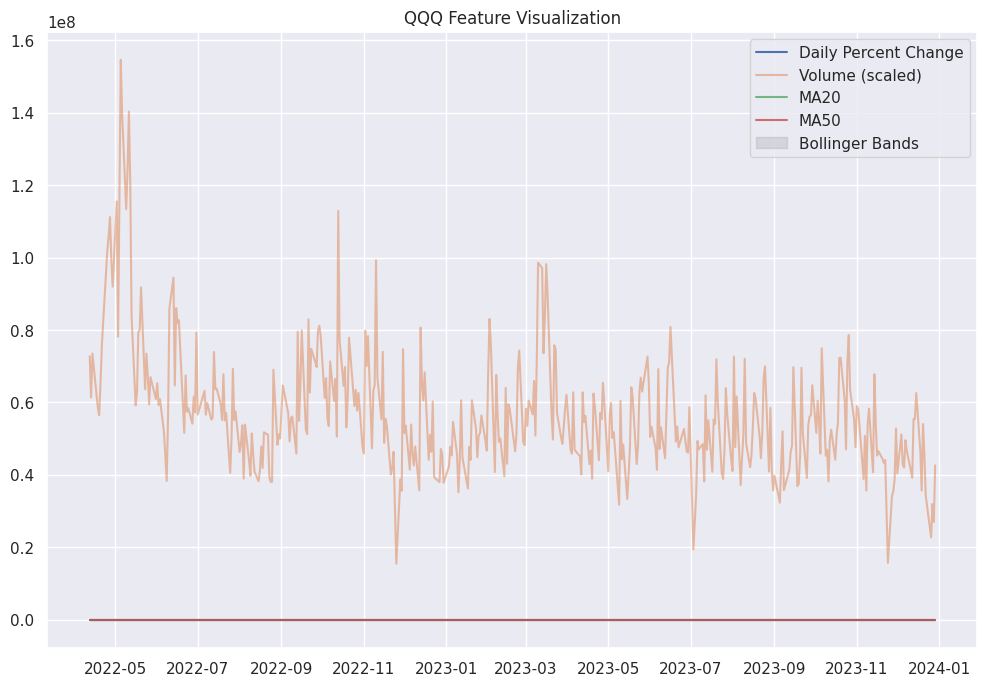

Silhouette Score for K-Means Clustering: 0.36


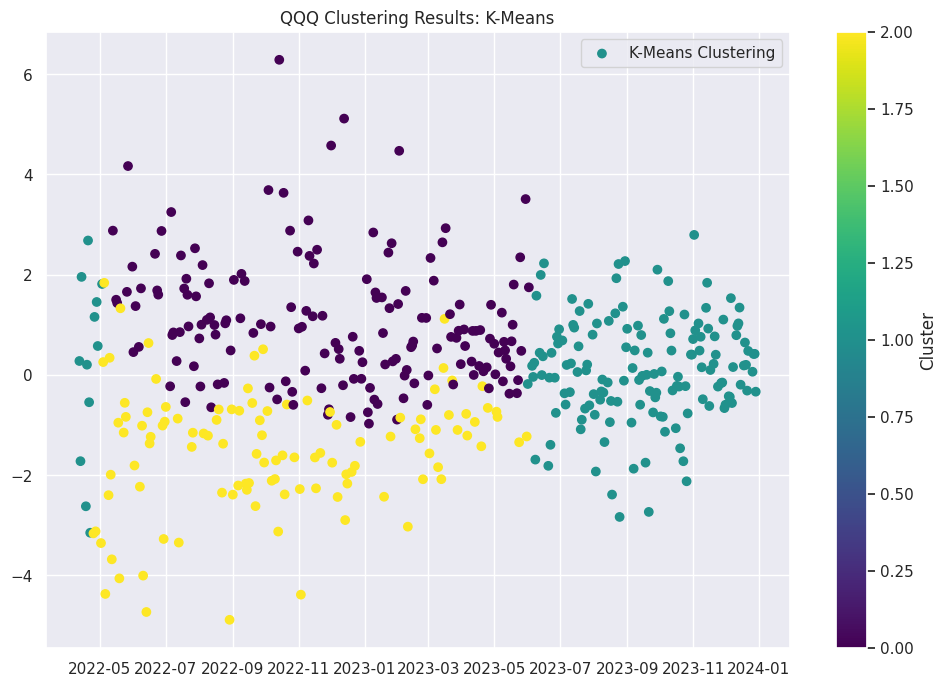

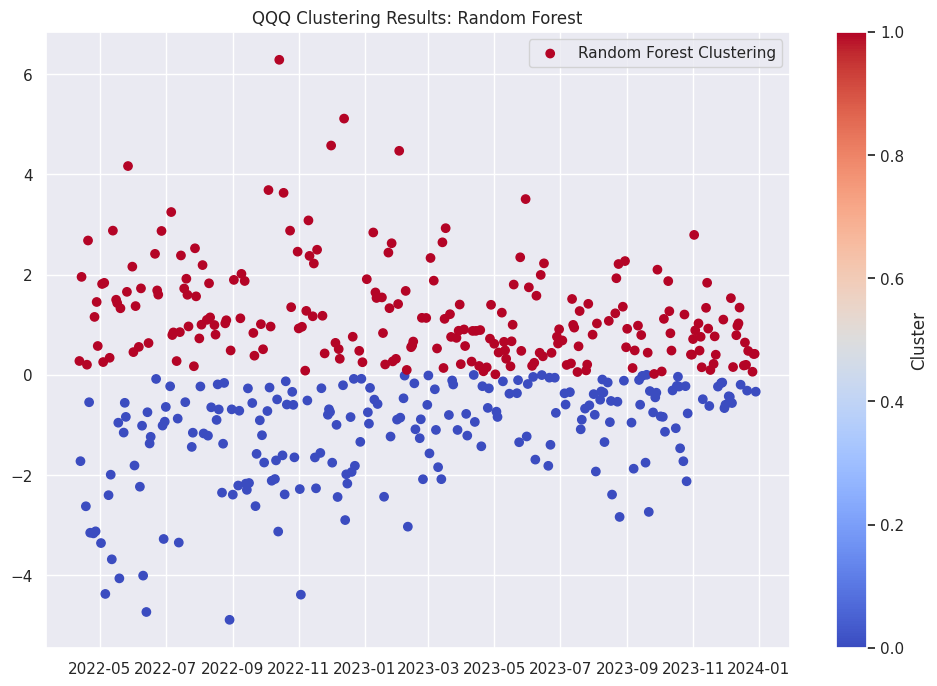

            Daily_Percent_Change  Cluster_KMeans  Cluster_RF
Date                                                        
2022-04-12              0.275518               1           1
2022-04-13             -1.723745               1           0
2022-04-14              1.954095               1           1
2022-04-18             -2.623830               1           0
2022-04-19              0.201569               1           1


In [310]:
import yfinance as yf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
#*************************************************** OLD CODE FROM TWO WEEKS AGO DO NOT USE
# Fetch stock data
ticker = 'QQQ'
stock_data = yf.download(ticker, start='2022-01-01', end='2024-01-01')

# Basic preprocessing
stock_data.dropna(inplace=True)
print(f"Stock data shape after cleaning: {stock_data.shape}")

# Existing feature calculation code

# Create DataFrame with column titles
stock_data = pd.DataFrame(stock_data)
stock_data.columns = ['Date', 'Open', 'High', 'Low', 'Close', 'Volume']

# Calculate additional columns

# Moving Averages (MA)
stock_data['MA50'] = stock_data['Close'].rolling(window=50).mean()
stock_data['MA20'] = stock_data['Close'].rolling(window=20).mean()

# Daily Percentage Move
stock_data['Daily_Percent_Change'] = stock_data['Close'].pct_change() * 100

# Daily Price Range
stock_data['Daily_Range'] = stock_data['High'] - stock_data['Low']

# Skip the first few rows to avoid NaN values due to moving averages
stock_data = stock_data.iloc[50:]  # Adjust window size as needed
# Handle Missing Values in Moving Averages:
#    Use fillna to fill missing values with a specific value (e.g., 0) or a more sophisticated imputation technique.
# Rest of the code remains the same...
# Handle missing values (e.g., fill with 0 or use imputation techniques)
#stock_data.fillna(0, inplace=True)

# Skip initial rows with NaN values
#stock_data = stock_data.iloc[100:]

stock_data['BB_upper'] = stock_data['MA20'] + (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)
stock_data['BB_lower'] = stock_data['MA20'] - (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)

# Ensure the result of the rolling calculation is a Series by using .values
#stock_data['BB_upper'] = stock_data['MA20'] + (2 * stock_data['Close'].rolling(window=20).std(ddof=0)['Close'])
#stock_data['BB_upper'] = stock_data['MA20'] + (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)
#stock_data['BB_lower'] = stock_data['MA20'] - (2 * stock_data['Close'].rolling(window=20).std(ddof=0).values)
stock_data['Daily_Percent_Change'] = stock_data['Close'].pct_change() * 100
stock_data['Volume'] = stock_data['Volume']

stock_data.dropna(inplace=True)

print(f"Stock data shape after cleaning: {stock_data.shape}")
# Visualize the features
plt.figure(figsize=(12, 8))
plt.plot(stock_data.index, stock_data['Daily_Percent_Change'], label='Daily Percent Change')
plt.plot(stock_data.index, stock_data['Volume'], label='Volume (scaled)', alpha=0.5)
plt.plot(stock_data.index, stock_data['MA20'], label='MA20', alpha=0.8)
plt.plot(stock_data.index, stock_data['MA50'], label='MA50', alpha=0.8)
plt.fill_between(stock_data.index, stock_data['BB_upper'], stock_data['BB_lower'], color='gray', alpha=0.2, label='Bollinger Bands')
plt.legend()
plt.title(f"{ticker} Feature Visualization")
plt.show()

# Prepare data for clustering
features = stock_data[['Daily_Percent_Change', 'Volume', 'MA20', 'MA50', 'BB_upper', 'BB_lower']]
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# K-Means Clustering
kmeans = KMeans(n_clusters=3, random_state=42)
stock_data['Cluster_KMeans'] = kmeans.fit_predict(scaled_features)

# Random Forest for supervised clustering
# Create a target variable: for simplicity, we classify into up/down based on daily percent change
stock_data['Target'] = np.where(stock_data['Daily_Percent_Change'] > 0, 1, 0)

# Random Forest Classifier
rf = RandomForestClassifier(random_state=42)
rf.fit(scaled_features, stock_data['Target'])

# Add Random Forest Predictions
stock_data['Cluster_RF'] = rf.predict(scaled_features)

# Evaluate clustering using silhouette score (for K-Means)
silhouette_avg = silhouette_score(scaled_features, stock_data['Cluster_KMeans'])
print(f"Silhouette Score for K-Means Clustering: {silhouette_avg:.2f}")

# Plot the clustering results
plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_KMeans'], cmap='viridis', label='K-Means Clustering')
plt.title(f"{ticker} Clustering Results: K-Means")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

plt.figure(figsize=(12, 8))
plt.scatter(stock_data.index, stock_data['Daily_Percent_Change'], c=stock_data['Cluster_RF'], cmap='coolwarm', label='Random Forest Clustering')
plt.title(f"{ticker} Clustering Results: Random Forest")
plt.colorbar(label='Cluster')
plt.legend()
plt.show()

# Summary and insights
print(stock_data[['Daily_Percent_Change', 'Cluster_KMeans', 'Cluster_RF']].head())
# Visualize the features (adjust plot to include new columns)
# ...



